In [1]:
import numpy as np

In [2]:
from scipy import linalg

In [3]:
def compare(A, B):
    A = A.round(5)
    B = B.round(5)
    return np.array_equal(A, B)

In [4]:
def rescale(A, B, i, j):
    A = A / A[i][j]
    A = A * B[i][j]
    return A

# NAIVE ALGORITHM

In [5]:
class Naive:
    def __init__(self, original, projected):
        self.original = original
        self.projected = projected
        
    def calcProjectionMatrix(self):
        g = self._constructProjectionMatrix(self.original, self._calcCoefficents(self.original))
        h = self._constructProjectionMatrix(self.projected, self._calcCoefficents(self.projected))
        f = np.matmul(h, np.linalg.inv(g))
        return f
    
    def _calcCoefficents(self, points):
        A = np.transpose(points[:3])
        b = points[3]
        coefficients = np.linalg.solve(A, b)
        return coefficients
    
    def _constructProjectionMatrix(self, points, coefficients):
        A = np.transpose(points[:3])
        A = A * coefficients
        return A

# DLT ALGORITHM

In [6]:
class DLT:
    def __init__(self, original, projected):
        self.original = original
        self.projected = projected
    
    def calcProjectionMatrix(self):
        M = self._constructMatrix()
        #print(M)
        _, _, Vt = np.linalg.svd(M)
        Vt = np.transpose(Vt)
        #print(np.matrix(Vt))
        P = Vt[:,-1]
        P = np.reshape(P, (3, 3))
        return P
    
    def _constructMatrix(self):
        n = len(self.original)
        M = []
        for i in range(n):
            subMatrix = self._getTwoEquations(self.original[i], self.projected[i])
            M.append(subMatrix[0])
            M.append(subMatrix[1])
        
        return np.array(M)
        
    def _getTwoEquations(self, original, projected):
        x1_x3p = original[0] * projected[2]
        x2_x3p = original[1] * projected[2]
        x3_x3p = original[2] * projected[2]
        
        x1_x2p = original[0] * projected[1]
        x2_x2p = original[1] * projected[1]
        x3_x2p = original[2] * projected[1]
        
        x1_x1p = original[0] * projected[0]
        x2_x1p = original[1] * projected[0]
        x3_x1p = original[2] * projected[0]
        
        m = [[     0,      0,      0, -x1_x3p, -x2_x3p, -x3_x3p,  x1_x2p,  x2_x2p,  x3_x2p],
             [x1_x3p, x2_x3p, x3_x3p,       0,       0,       0, -x1_x1p, -x2_x1p, -x3_x1p]]
        return m

# DLT NORMALIZED

In [7]:
class DLTNormalized:
    def __init__(self, original, projected):
        self.original = original
        self.projected = projected
    
    def calcProjectionMatrix(self):
        self.original, T = self._normalize(self.original)
        self.projected, Tp = self._normalize(self.projected)
        
        
        # Medjurezultati
        
        #print(np.matrix(T))
        #print(np.matrix(Tp))
        #print(self.original)
        #print(self.projected)
        
        M = self._constructMatrix()
        _, _, Vt = np.linalg.svd(M)
        Vt = np.transpose(Vt)
        #print(np.matrix(Vt))
        P = Vt[:,-1]
        P = np.reshape(P, (3, 3))
        
        #print(P)
        
        P = np.matmul(np.matmul(np.linalg.inv(Tp), P), T)
        return P
    
    def _constructMatrix(self):
        n = len(self.original)
        M = []
        for i in range(n):
            subMatrix = self._getTwoEquations(self.original[i], self.projected[i])
            M.append(subMatrix[0])
            M.append(subMatrix[1])
        
        return np.array(M)
        
    def _getTwoEquations(self, original, projected):
        x1_x3p = original[0] * projected[2]
        x2_x3p = original[1] * projected[2]
        x3_x3p = original[2] * projected[2]
        
        x1_x2p = original[0] * projected[1]
        x2_x2p = original[1] * projected[1]
        x3_x2p = original[2] * projected[1]
        
        x1_x1p = original[0] * projected[0]
        x2_x1p = original[1] * projected[0]
        x3_x1p = original[2] * projected[0]
        
        m = [[     0,      0,      0, -x1_x3p, -x2_x3p, -x3_x3p,  x1_x2p,  x2_x2p,  x3_x2p],
             [x1_x3p, x2_x3p, x3_x3p,       0,       0,       0, -x1_x1p, -x2_x1p, -x3_x1p]]
        return m
    
    def _affinize(self, points):
        newPoints = []
        for point in points:
            newPoints.append([point[0]/point[2], point[1]/point[2]])
        return np.array(newPoints)
        
    def _normalize(self, points):
        oldPoints = points
        n = len(points)
        
        #Affinize
        points = self._affinize(points)
        
        #Calc center
        C = [0, 0]
        for point in points:
            C += point
        C = C/n
        
        #Translate
        for i in range(n):
            points[i] -= C
        
        #Scale
        d = 0
        for point in points:
            d += np.linalg.norm(point)
        d = d/n
        alfa = np.sqrt(2)/d
        
        # Transform old points
        T = [[alfa,    0, -C[0]*alfa],
             [   0, alfa, -C[1]*alfa],
             [   0,    0,          1]]
    
        points = []
        for point in oldPoints:
            points.append(np.matmul(T, point))
            
        return np.array(points), T

# Testing : Model za odbranu domaceg

In [8]:
P = np.array(
    [[0,   3, 5],
     [4,   0, 0],
     [-1, -1, 6]])

In [9]:
a = [-3, 2, 1]
b = [-2, 5, 2]
c = [1, 0, 3]
d = [-7, 3, 1]
e = [2, 1, 2]
f = [-1, 2, 1]
g = [1, 1, 1]

In [10]:
ap = np.matmul(P, a)
bp = np.matmul(P, b)
cp = np.matmul(P, c)
dp = np.matmul(P, d)
ep = [13, 8, 9]
fp = [11, -4, 5]
gp = [8.02, 4, 4]

In [11]:
originals = [a, b, c, d, e, f, g]
images = [ap, bp, cp, dp, ep, fp, gp] 

### Naive

In [12]:
alg = Naive(originals, images)
P_naive = alg.calcProjectionMatrix()
print(np.matrix(P_naive))

[[ 1.44328993e-15  3.00000000e+00  5.00000000e+00]
 [ 4.00000000e+00 -3.88578059e-16  2.22044605e-16]
 [-1.00000000e+00 -1.00000000e+00  6.00000000e+00]]


In [13]:
if compare(P_naive, P):
    print('Same matrix')
else:
    print('Error!!!')

Same matrix


### DLT

In [14]:
alg = DLT(originals, images)
P_dlt = alg.calcProjectionMatrix()
print(np.matrix(P_dlt))

[[ 5.30528511e-05  3.20011319e-01  5.32929220e-01]
 [ 4.26445525e-01 -2.02187024e-05 -2.95145391e-05]
 [-1.06595323e-01 -1.06519060e-01  6.39542445e-01]]


In [15]:
P_dlt = rescale(P_dlt, P_naive, 0, 1)
P_dlt

array([[ 4.97352886e-04,  3.00000000e+00,  4.99603472e+00],
       [ 3.99778538e+00, -1.89543630e-04, -2.76689017e-04],
       [-9.99295809e-01, -9.98580867e-01,  5.99549835e+00]])

In [16]:
if compare(P_dlt, P_naive):
    print('DLT and Naive matrices are the same.')
else:
    print('DLT and Naive matrices are different.')

DLT and Naive matrices are different.


#### Naive vs DLT on 4 points

In [17]:
myOriginals = [[-4, -2, 1], [2, -2, 1], [1, 3, 1], [-3, 3, 1]]
myImages = [[-3, -2, 1], [3, -2 , 1], [3, 2, 1], [-3, 2, 1]]

In [18]:
alg = Naive(myOriginals, myImages)
P1 = alg.calcProjectionMatrix()
print(np.matrix(P1))

[[ 1.5  0.   1.5]
 [ 0.   1.  -1. ]
 [ 0.  -0.1  1.3]]


In [19]:
alg = DLT(myOriginals, myImages)
P2 = alg.calcProjectionMatrix()
print(np.matrix(P2))

[[ 5.23822722e-01  1.38777878e-17  5.23822722e-01]
 [-1.11022302e-16  3.49215148e-01 -3.49215148e-01]
 [ 2.22044605e-16 -3.49215148e-02  4.53979692e-01]]


In [20]:
P2 = rescale(P2, P1, 0, 0)
P2

array([[ 1.50000000e+00,  3.97399365e-17,  1.50000000e+00],
       [-3.17919492e-16,  1.00000000e+00, -1.00000000e+00],
       [ 6.35838984e-16, -1.00000000e-01,  1.30000000e+00]])

In [21]:
if compare(P1, P2):
    print('DLT and Naive matrices are the same.')
else:
    print('DLT and Naive matrices are different.')

DLT and Naive matrices are the same.


### Normalized DLT

In [22]:
alg = DLTNormalized(originals, images)
P_normalized = alg.calcProjectionMatrix()
print(np.matrix(P_normalized))

[[-3.89785465e-05 -2.34697334e-01 -3.90851376e-01]
 [-3.12756187e-01  1.48613871e-05  2.16907546e-05]
 [ 7.81772458e-02  7.81212009e-02 -4.69041798e-01]]


In [23]:
P_normalized = rescale(P_normalized, P_naive, 0, 1)
P_normalized

array([[ 4.98240170e-04,  3.00000000e+00,  4.99602662e+00],
       [ 3.99778107e+00, -1.89964499e-04, -2.77260345e-04],
       [-9.99294424e-01, -9.98578036e-01,  5.99548946e+00]])

In [24]:
if compare(P_normalized, P_dlt):
    print('DLT and Normalized DLT matrices are the same.')
else:
    print('DLT and Normalized DLT matrices are different.')

DLT and Normalized DLT matrices are different.


### The DLT algorithm is not invariant to coordinate change

In [25]:
C  = [[0,  1, 2],
      [-1, 0, 3],
      [0,  0, 1]]

In [26]:
changed_originals = [np.matmul(C, x) for x in originals]
changed_images = [np.matmul(C, x) for x in images]
print(changed_originals)
print(changed_images)

[array([4, 6, 1]), array([9, 8, 2]), array([6, 8, 3]), array([ 5, 10,  1]), array([5, 4, 2]), array([4, 4, 1]), array([3, 2, 1])]
[array([ 2, 10,  7]), array([10,  2,  9]), array([38, 36, 17]), array([-8, 16, 10]), array([26, 14,  9]), array([6, 4, 5]), array([12.  ,  3.98,  4.  ])]


In [27]:
alg = DLT(changed_originals, changed_images)
P_dlt_changed = alg.calcProjectionMatrix()

P_dlt_changed = np.matmul(np.matmul(np.linalg.inv(C), P_dlt_changed), C)

print(np.matrix(P_dlt_changed))

[[-1.73564676e-05 -1.04847554e-01 -1.74607666e-01]
 [-1.39719503e-01  6.61760914e-06  9.63372330e-06]
 [ 3.49246285e-02  3.48997143e-02 -2.09538156e-01]]


In [28]:
P_dlt_changed = rescale(P_dlt_changed, P_naive, 0, 1)
P_dlt_changed

array([[ 4.96620099e-04,  3.00000000e+00,  4.99604404e+00],
       [ 3.99779004e+00, -1.89349457e-04, -2.75649443e-04],
       [-9.99297373e-01, -9.98584504e-01,  5.99550913e+00]])

In [29]:
if not compare(P_dlt_changed, P_dlt):
    print('DLT is not invariant to coordinate change.')
else:
    print('Error!!!')

DLT is not invariant to coordinate change.


### Normalized DLT is invariant to coordinate change

In [30]:
alg = DLTNormalized(changed_originals, changed_images)
P_normalized_changed = alg.calcProjectionMatrix()

P_normalized_changed = np.matmul(np.matmul(np.linalg.inv(C), P_normalized_changed), C)

print(np.matrix(P_normalized_changed))

[[-3.89785465e-05 -2.34697334e-01 -3.90851376e-01]
 [-3.12756187e-01  1.48613871e-05  2.16907546e-05]
 [ 7.81772458e-02  7.81212009e-02 -4.69041798e-01]]


In [31]:
P_normalized_changed = rescale(P_normalized_changed, P_naive, 0, 1)
P_normalized_changed

array([[ 4.98240170e-04,  3.00000000e+00,  4.99602662e+00],
       [ 3.99778107e+00, -1.89964499e-04, -2.77260345e-04],
       [-9.99294424e-01, -9.98578036e-01,  5.99548946e+00]])

In [32]:
if compare(P_normalized_changed, P_normalized):
    print('Normalized DLT is invariant to coordinate change.')
else:
    print('Error!!!')

Normalized DLT is invariant to coordinate change.


# Testing 2

In [33]:
y1 = [2, 1, 1]
y2 = [1, 2, 1]
y3 = [3, 4, 1]
y4 = [-1, -3, 1]
y5 = [-2, 5 ,1]

y1p = [0, 1, 1]
y2p = [5, 0, 1]
y3p = [2, -5, 1]
y4p = [-1, -1, 1]
y5p = [4, 1 , 2]

In [34]:
yn1 = [0, -3, 1]
yn2 = [0, -1, 1]
yn3 = [4, -1, 1]
yn4 = [-7, -4, 1]
yn5 = [0, 5 ,1]

yn1p = [3, -1, 1]
yn2p = [4, 4, 1]
yn3p = [9, 1, 1]
yn4p = [5, -2, 1]
yn5p = [7, 2 , 2]

##### 1)  y1, y2, y3, y4 -> y1p, y2p, y3p, y4p (Naive, DLT, Normalized DLT)

In [35]:
originals = [y1, y2, y3, y4]
images = [y1p, y2p, y3p, y4p]

In [36]:
alg = Naive(originals, images)
P_naive = alg.calcProjectionMatrix()

P_naive = P_naive / P_naive[0][0]
print(np.matrix(P_naive))

[[ 1.         -0.4893617  -1.5106383 ]
 [ 0.62765957 -0.04255319 -0.54255319]
 [ 0.5        -0.46808511  0.13829787]]


In [37]:
alg = DLT(originals, images)
P_dlt = alg.calcProjectionMatrix()

P_dlt = P_dlt / P_dlt[0][0]
print(np.matrix(P_dlt))

[[ 1.         -0.4893617  -1.5106383 ]
 [ 0.62765957 -0.04255319 -0.54255319]
 [ 0.5        -0.46808511  0.13829787]]


In [38]:
alg = DLTNormalized(originals, images)
P_dlt_normalized = alg.calcProjectionMatrix()

P_dlt_normalized = P_dlt_normalized / P_dlt_normalized[0][0]
print(np.matrix(P_dlt_normalized))

[[ 1.         -0.4893617  -1.5106383 ]
 [ 0.62765957 -0.04255319 -0.54255319]
 [ 0.5        -0.46808511  0.13829787]]


##### 2)  y1, y2, y3, y4, y5 -> y1p, y2p, y3p, y4p, y5p (DLT, Normalized DLT)

In [39]:
originals = [y1, y2, y3, y4, y5]
images = [y1p, y2p, y3p, y4p, y5p]

In [40]:
alg = DLT(originals, images)
P_dlt = alg.calcProjectionMatrix()

P_dlt = P_dlt / P_dlt[0][0]
print(np.matrix(P_dlt))

[[ 1.         -0.50215564 -1.45779447]
 [ 0.51618777 -0.00399712 -0.44345389]
 [ 0.46632343 -0.43192449  0.10723129]]


In [41]:
alg = DLTNormalized(originals, images)
P_dlt_normalized = alg.calcProjectionMatrix()

P_dlt_normalized = P_dlt_normalized / P_dlt_normalized[0][0]
print(np.matrix(P_dlt_normalized))

[[ 1.         -0.5023401  -1.45715674]
 [ 0.51610841 -0.00412933 -0.44312296]
 [ 0.46640067 -0.43189579  0.10703341]]


##### 3)  yn1, yn2, yn3, yn4, yn5 -> yn1p, yn2p, yn3p, yn4p, yn5p (Normalized DLT)

In [42]:
originals = [yn1, yn2, yn3, yn4, yn5]
images = [yn1p, yn2p, yn3p, yn4p, yn5p]

In [43]:
alg = DLTNormalized(originals, images)
P_dlt_normalized = alg.calcProjectionMatrix()

P_dlt_normalized = P_dlt_normalized / P_dlt_normalized[0][0]
print(np.matrix(P_dlt_normalized))

[[ 1.          8.21732732 14.77502463]
 [-1.23851632  1.61526461  7.88053805]
 [-0.09226902  2.40212193  3.95500375]]


# Projective distortion removal

In [44]:
import cv2
import matplotlib.pyplot as plt

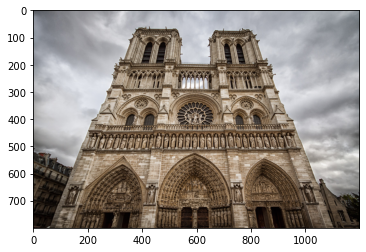

In [45]:
img = cv2.imread('image.bmp') 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [46]:
img.shape

(800, 1200, 3)

In [47]:
original =  [[58,  800, 1], [1110, 800, 1], [840,   55, 1], [ 347, 55, 1]]
projected = [[200, 800, 1], [1000, 800, 1], [1000, 30, 1], [200, 30, 1]]

In [48]:
alg = DLTNormalized(original, projected)
P = alg.calcProjectionMatrix()

In [49]:
dst = cv2.warpPerspective(img, P, dsize = (1200, 800))

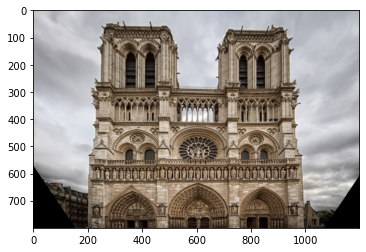

In [50]:
plt.imshow(dst)
plt.show()